In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [3]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [4]:
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20190409_2'
data_snippets_dir = 'ver4_machine_learning_flight_classification_tsne_cfg3_20190409_2'

os.makedirs(data_snippets_dir, exist_ok=True)

In [5]:
subset_classification_slug = 'ver4_ml_tsne_cfg3_20190409_2'

# Selecting the flight data

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Columns

In [7]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190409_2/rfecv_selector_on_extra_trees__column_names.txt


In [8]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190409_2/rfecv_selector_on_extra_trees__column_names__special.txt


In [9]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
        ('gps_datetime_min')
    ] + rfecv_selector_on_extra_trees__column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=rfecv_selector_on_extra_trees__column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- max_size_clu_height
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_height
	- max_peak_clu_height

WARNING: not selecting NULL trg lines

## Event classes

In [11]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21,
    #
    'unclassified': -1
}

In [12]:
len(EVENT_CLASSES)

23

In [13]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

## Constructing the query

In [14]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [15]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_per_gtu_sum, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean AS trg_pmt_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean_gz

In [16]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [17]:
manual_classification_class_number_column = 'manual_classification_class_number'

In [18]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = -1

In [19]:
len(flight_df)

146116

In [20]:
manual_classification_class_name_column = 'manual_classification_class_name'

In [21]:
flight_df[manual_classification_class_name_column] = 'unclassified'
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name

In [22]:
flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number,manual_classification_class_name
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,4.60184,5.41446,5.14926,27,15,27,27,27,-1.0,unclassified
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,1.70155,2.29509,3.20554,35,19,35,35,35,-1.0,unclassified
2,68,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,177,1,49,9,1.0,...,3.15889,1.96062,3.85617,84,25,84,84,84,-1.0,unclassified
3,72,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,287,2,31,9,1.0,...,2.76942,3.05407,2.90978,57,22,57,57,57,-1.0,unclassified
4,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,5.69936,5.69849,1.11428,46,45,46,46,46,-1.0,unclassified


In [23]:
flight_df[rfecv_selector_on_extra_trees__column_names].head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_count,trg_x_y_clusters_sizes_min,...,alt1_gtu_x_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size
0,11,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,2,1,...,74,74,4.60184,5.41446,5.14926,27,15,27,27,27
1,11,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,1,7,...,38,38,1.70155,2.29509,3.20554,35,19,35,35,35
2,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,74,74,3.15889,1.96062,3.85617,84,25,84,84,84
3,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,52,52,2.76942,3.05407,2.90978,57,22,57,57,57
4,22,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,1,16,...,26,26,5.69936,5.69849,1.11428,46,45,46,46,46


In [24]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [25]:
flight_df['had_nan_fields'] = flight_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1)

In [26]:
np.count_nonzero(flight_df['had_nan_fields'])

0

In [27]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [28]:
len(flight_df_nonan)

146116

In [29]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;


In [30]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [31]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

In [32]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))

number of all         packets 145648
number of gtu [36,60] packets 137363
number of gtu [31,67] packets 139935
--------------------------------------------------
number of all         events  243622
number of gtu [36,60] events  156135
number of gtu [31,67] events  167354
--------------------------------------------------
sel. fraction of all         events 0.600
sel. fraction of gtu [36,60] events 0.936
sel. fraction of gtu [31,67] events 0.873


# Applying models

This model does not use scaled data

In [33]:
# standard_scaler_on_train_rfecv_columns_pathname = \
#      os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
# standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [34]:
# flight__rfecv_columns_scaled_X = \
#     standard_scaler_on_train_rfecv_columns.transform(
#         flight_df[rfecv_selector_on_extra_trees__column_names].values)
# if np.count_nonzero(flight_df['had_nan_fields']) > 0:
#     flight_nonan__rfecv_columns_scaled_X = \
#         standard_scaler_on_train_rfecv_columns.transform(
#             flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values)
# else:
#     flight_nonan__rfecv_columns_scaled_X = flight__rfecv_columns_scaled_X

## Extra trees classifier

In [35]:
flight_rfecv_columns__X  = flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values

In [36]:
extra_trees_cls_on_train_rfecv__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
extra_trees_cls_on_train_rfecv_est = joblib.load(extra_trees_cls_on_train_rfecv__model_plk_pathname)

In [37]:
cls_column_base = 'extra_trees_cls_on_train_rfecv_est'
cls_column = cls_column_base + '_dropna'
cls_proba_column = 'extra_trees_cls_on_train_rfecv_est_dropna_proba'

In [38]:
# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )
flight_df[cls_column_base] = \
    extra_trees_cls_on_train_rfecv_est.predict(flight_rfecv_columns__X)

flight_df[cls_column] = \
    ((flight_df[cls_column_base]==1) & ~flight_df['had_nan_fields']).astype('int8')

In [39]:
flight_df[cls_proba_column] = np.nan
flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), cls_proba_column] = \
    extra_trees_cls_on_train_rfecv_est.predict_proba(flight_rfecv_columns__X)[:,1]

### Updating `flight_df_nonan` with classification predictions
(not in the report)

In [40]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [41]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_count,trg_x_y_clusters_sizes_min,...,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number
0,11,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,2,1,...,74,4.60184,5.41446,5.14926,27,15,27,27,27,-1.0
1,11,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,1,7,...,38,1.70155,2.29509,3.20554,35,19,35,35,35,-1.0
2,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,74,3.15889,1.96062,3.85617,84,25,84,84,84,-1.0
3,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,52,2.76942,3.05407,2.90978,57,22,57,57,57,-1.0
4,22,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,1,16,...,26,5.69936,5.69849,1.11428,46,45,46,46,46,-1.0


### Statistics of selected events

In [42]:
np.count_nonzero(flight_df[cls_column])

14722

In [43]:
np.count_nonzero(flight_df[cls_column])/len(flight_df)

0.10075556407238084

In [44]:
flight_df[[cls_column, cls_proba_column]].describe()

,extra_trees_cls_on_train_rfecv_est_dropna,extra_trees_cls_on_train_rfecv_est_dropna_proba
count,146116.000000,146116.000000
mean,0.100756,0.202417
std,0.301006,0.189851
min,0.000000,0.000000
25%,0.000000,0.049876
50%,0.000000,0.138805
75%,0.000000,0.305594
max,1.000000,0.997668


#### Events classified "air shower" - number of events by probability

In [45]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df[cls_proba_column] > proba)))

p > 0.50: 14722
p > 0.60: 7959
p > 0.70: 2238
p > 0.80: 551
p > 0.90: 165


#### Events classified "air shower" - fraction of all events

In [46]:
np.count_nonzero(flight_df_nonan[cls_column])/num_all_events

0.060429682048419274

#### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [47]:
np.count_nonzero(flight_df_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.07276395427034298

#### Packets classified "air shower" - fraction of all packets

In [48]:
num_cls_1_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [49]:
num_cls_1_packets/num_all_packets

0.08964077776557179

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [50]:
num_cls_1_gtu_36_60_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [51]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_events

0.06781951516316008

### Distribution of classified events by date

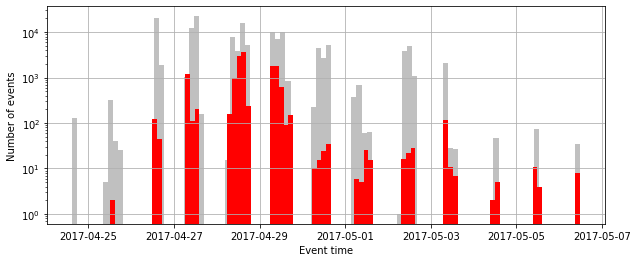

In [52]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red')
ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
plt.show()

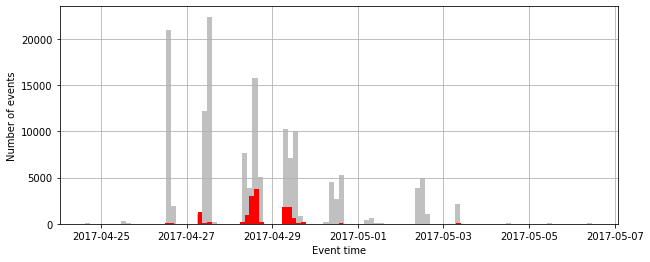

In [53]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red')
# ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
plt.show()

### Trigger rate

#### All flight HW events

In [54]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [55]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

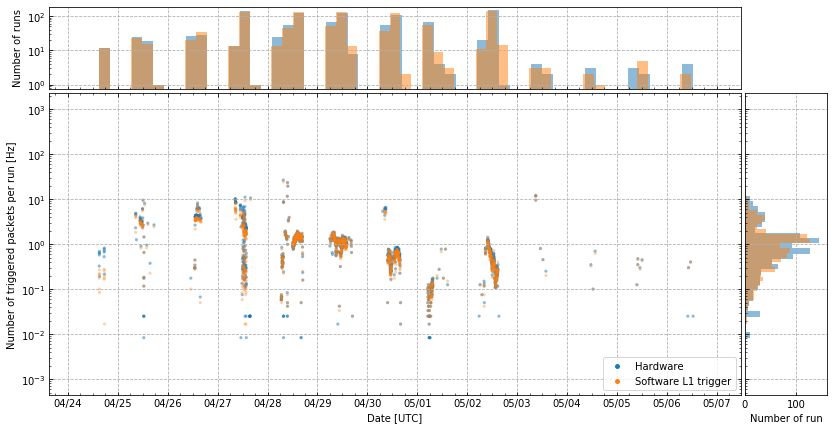

In [56]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);
# dodgerblue

#### All classified events

In [57]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

1/987 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/987 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/987 allpackets-SPBEUSO-ACQUISITION-20170425-104043-001.001--CHECK.root
14/987 allpackets-SPBEUSO-ACQUISITION-20170425-104127-002

116/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-003.001--LONG-sqz.root
117/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz-dis.root
118/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz.root
119/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz-dis.root
120/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz.root
121/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz-dis.root
122/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz.root
123/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz-dis.root
124/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz.root
125/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz-dis.root
126/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz.root
127/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-009.001--LONG-sqz-dis.root
128/987 allpackets-SPBEUSO-ACQUISITION-2

227/987 allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root
 > SKIPPING
228/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-009.001--LONG.root
229/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-010.001--LONG.root
230/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-013.001--LONG.root
231/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-014.001--LONG.root
232/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-015.001--LONG.root
233/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-017.001--LONG.root
234/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-018.001--LONG.root
235/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-019.001--LONG.root
236/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-020.001--LONG.root
237/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-027.001--LONG.root
238/987 allpackets-SPBEUSO-ACQUISITION-20170428-081641-001.001--CHECK.root
239/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-006.001--LONG.root
240/987 allpackets-SPBEUSO-AC

338/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-017.001--LONG.root
339/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-018.001--LONG.root
340/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-019.001--LONG.root
341/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-020.001--LONG.root
342/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-021.001--LONG.root
343/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-022.001--LONG.root
344/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-023.001--LONG.root
345/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-024.001--LONG.root
346/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-025.001--LONG.root
347/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-026.001--LONG.root
348/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-027.001--LONG.root
349/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-028.001--LONG.root
350/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-029.001--LONG.root
351/987 allpackets-SPBEUSO-ACQUISITION

460/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-023.001--LONG-sqz.root
461/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-001.001--LONG-sqz.root
462/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG.root
463/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-004.001--LONG.root
464/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-006.001--LONG-sqz.root
465/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-009.001--LONG.root
466/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-010.001--LONG-sqz.root
467/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-010.001--LONG.root
468/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-014.001--LONG-sqz.root
469/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-015.001--LONG.root
470/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-017.001--LONG.root
471/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-018.001--LONG-sqz.root
472/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-018.001--LONG.root
473/987 allpac

572/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-029.001--LONG-sqz.root
573/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-030.001--LONG-sqz.root
574/987 allpackets-SPBEUSO-ACQUISITION-20170429-140717-001.001--CHECK.root
575/987 allpackets-SPBEUSO-ACQUISITION-20170429-140801-029.001--LONG.root
576/987 allpackets-SPBEUSO-ACQUISITION-20170429-150821-001.001--CHECK.root
577/987 allpackets-SPBEUSO-ACQUISITION-20170429-160925-001.001--CHECK.root
578/987 allpackets-SPBEUSO-ACQUISITION-20170429-161009-001.001--LONG.root
579/987 allpackets-SPBEUSO-ACQUISITION-20170429-161009-003.001--LONG.root
580/987 allpackets-SPBEUSO-ACQUISITION-20170429-161009-004.001--LONG.root
581/987 allpackets-SPBEUSO-ACQUISITION-20170429-161009-007.001--LONG.root
582/987 allpackets-SPBEUSO-ACQUISITION-20170429-165010-001.001--LONG.root
583/987 allpackets-SPBEUSO-ACQUISITION-20170430-072445-001.001--CHECK.root
584/987 allpackets-SPBEUSO-ACQUISITION-20170430-081837-001.001--CHECK-sqz.root
585/987 allpackets-SP

684/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-008.001--LONG-sqz.root
685/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-009.001--LONG-sqz.root
686/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-010.001--LONG-sqz.root
687/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-011.001--LONG-sqz.root
688/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-012.001--LONG-sqz.root
689/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-013.001--LONG-sqz.root
690/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-014.001--LONG-sqz.root
691/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-016.001--LONG-sqz.root
692/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-017.001--LONG-sqz.root
693/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-018.001--LONG-sqz.root
694/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-019.001--LONG-sqz.root
695/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-020.001--LONG-sqz.root
696/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-021.001--

822/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-004.001--LONG-sqz.root
823/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-005.001--LONG-sqz.root
824/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-006.001--LONG-sqz.root
825/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-007.001--LONG-sqz.root
826/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-008.001--LONG-sqz.root
827/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-009.001--LONG-sqz.root
828/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-010.001--LONG-sqz.root
829/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
830/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
831/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
832/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
833/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-015.001--LONG-sqz.root
834/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-016.001--

972/987 allpackets-SPBEUSO-ACQUISITION-20170502-144913-001.001--CHECK.root
973/987 allpackets-SPBEUSO-ACQUISITION-20170503-085415-001.001--CHECK.root
974/987 allpackets-SPBEUSO-ACQUISITION-20170503-085728-001.001--CHECK.root
975/987 allpackets-SPBEUSO-ACQUISITION-20170503-090032-001.001--CHECK.root
976/987 allpackets-SPBEUSO-ACQUISITION-20170503-111308-001.001--CHECK.root
977/987 allpackets-SPBEUSO-ACQUISITION-20170503-122552-001.001--CHECK.root
978/987 allpackets-SPBEUSO-ACQUISITION-20170503-135121-001.001--CHECK.root
979/987 allpackets-SPBEUSO-ACQUISITION-20170504-113024-001.001--CHECK.root
980/987 allpackets-SPBEUSO-ACQUISITION-20170504-123121-001.001--CHECK.root
981/987 allpackets-SPBEUSO-ACQUISITION-20170504-133219-001.001--CHECK.root
982/987 allpackets-SPBEUSO-ACQUISITION-20170505-100211-001.001--CHECK.root
983/987 allpackets-SPBEUSO-ACQUISITION-20170505-100435-001.001--CHECK.root
984/987 allpackets-SPBEUSO-ACQUISITION-20170505-110545-001.001--CHECK.root
985/987 allpackets-SPBEUS

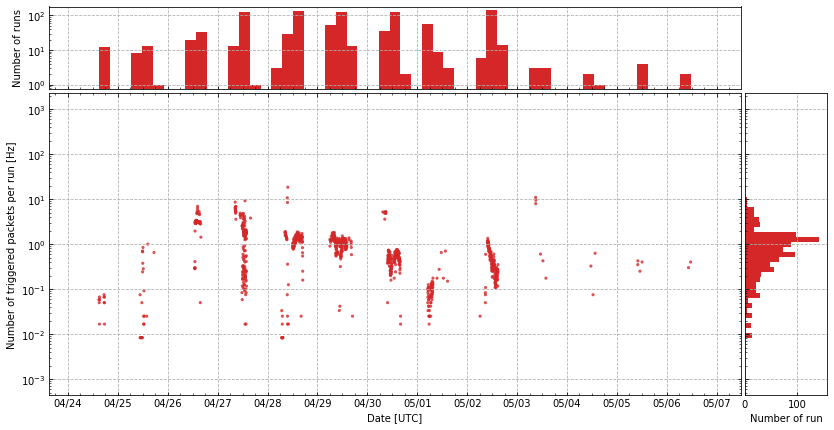

In [58]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all.png')
);
# limegreen

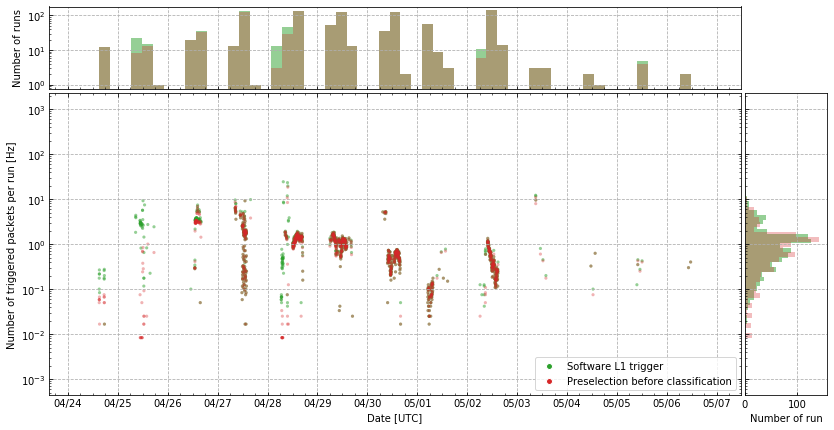

In [59]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Events classified as "air shower"

In [60]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan[flight_df_nonan[cls_column] == 1],  one_trg_per='packet')

1/451 allpackets-SPBEUSO-ACQUISITION-20170425-115921-004.001--LONG.root
2/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-001.001--LONG.root
3/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-002.001--LONG.root
4/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-005.001--LONG.root
5/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-006.001--LONG.root
6/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-007.001--LONG.root
7/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-008.001--LONG.root
8/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-009.001--LONG.root
9/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-011.001--LONG.root
10/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-012.001--LONG.root
11/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-013.001--LONG.root
12/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-014.001--LONG.root
13/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-015.001--LONG.root
14/451 allpackets-SPBEUSO-ACQUISITION-20170426-125930-016.00

119/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-016.001--LONG.root
120/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-017.001--LONG.root
121/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-018.001--LONG.root
122/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-019.001--LONG.root
123/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-020.001--LONG.root
124/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-021.001--LONG.root
125/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-022.001--LONG.root
126/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-023.001--LONG.root
127/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-024.001--LONG.root
128/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-025.001--LONG.root
129/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-026.001--LONG.root
130/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-027.001--LONG.root
131/451 allpackets-SPBEUSO-ACQUISITION-20170428-120707-028.001--LONG.root
132/451 allpackets-SPBEUSO-ACQUISITION

235/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-001.001--LONG.root
236/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-007.001--LONG.root
237/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-010.001--LONG.root
238/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-014.001--LONG.root
239/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-019.001--LONG.root
240/451 allpackets-SPBEUSO-ACQUISITION-20170429-055927-024.001--LONG.root
241/451 allpackets-SPBEUSO-ACQUISITION-20170429-065947-001.001--CHECK.root
242/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-003.001--LONG.root
243/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-004.001--LONG.root
244/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-006.001--LONG.root
245/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-008.001--LONG.root
246/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-009.001--LONG.root
247/451 allpackets-SPBEUSO-ACQUISITION-20170429-070031-012.001--LONG.root
248/451 allpackets-SPBEUSO-ACQUISITIO

378/451 allpackets-SPBEUSO-ACQUISITION-20170430-115225-001.001--CHECK.root
379/451 allpackets-SPBEUSO-ACQUISITION-20170430-125414-001.001--LONG-sqz.root
380/451 allpackets-SPBEUSO-ACQUISITION-20170430-125414-008.001--LONG-sqz.root
381/451 allpackets-SPBEUSO-ACQUISITION-20170430-125414-014.001--LONG-sqz.root
382/451 allpackets-SPBEUSO-ACQUISITION-20170430-125414-016.001--LONG-sqz.root
383/451 allpackets-SPBEUSO-ACQUISITION-20170430-133518-001.001--CHECK.root
384/451 allpackets-SPBEUSO-ACQUISITION-20170430-133603-001.001--LONG-sqz.root
385/451 allpackets-SPBEUSO-ACQUISITION-20170430-133603-011.001--LONG-sqz.root
386/451 allpackets-SPBEUSO-ACQUISITION-20170430-133603-014.001--LONG-sqz.root
387/451 allpackets-SPBEUSO-ACQUISITION-20170430-133603-030.001--LONG-sqz.root
388/451 allpackets-SPBEUSO-ACQUISITION-20170430-143623-001.001--CHECK.root
389/451 allpackets-SPBEUSO-ACQUISITION-20170430-143708-002.001--LONG-sqz.root
390/451 allpackets-SPBEUSO-ACQUISITION-20170430-143708-004.001--LONG-sqz.

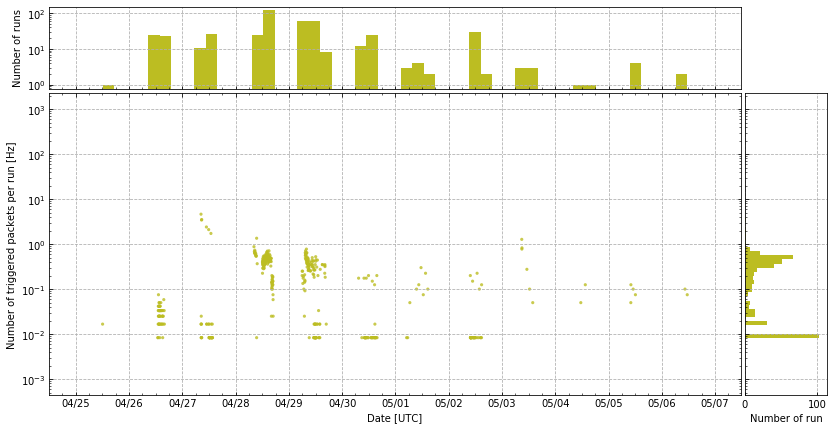

In [61]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_air_shower.png')
);

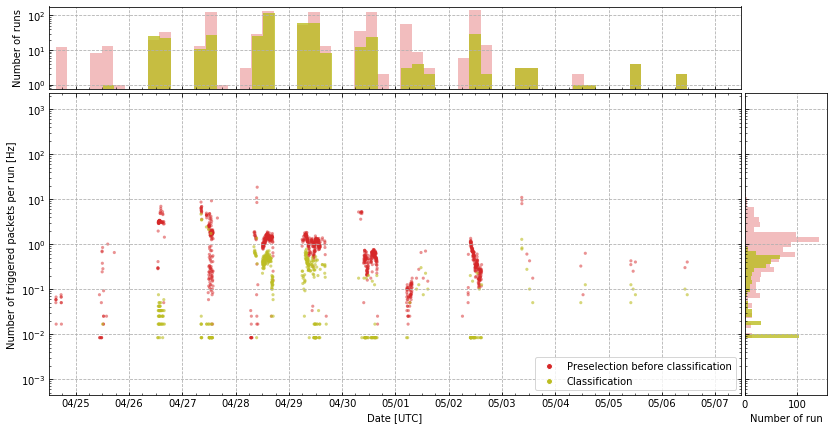

In [62]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

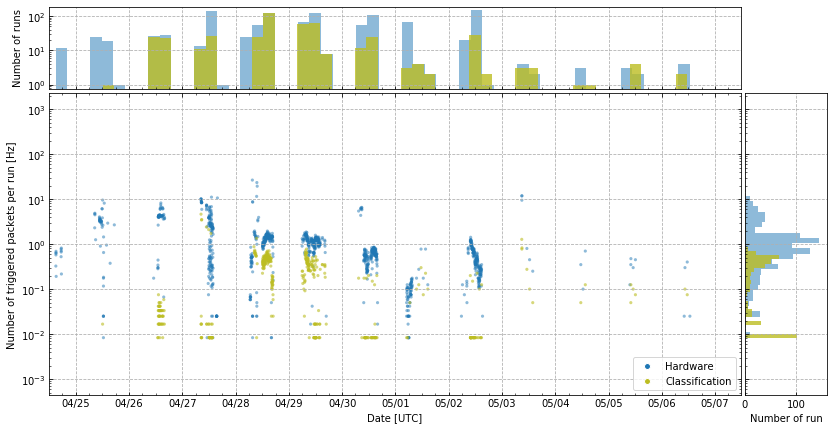

In [63]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

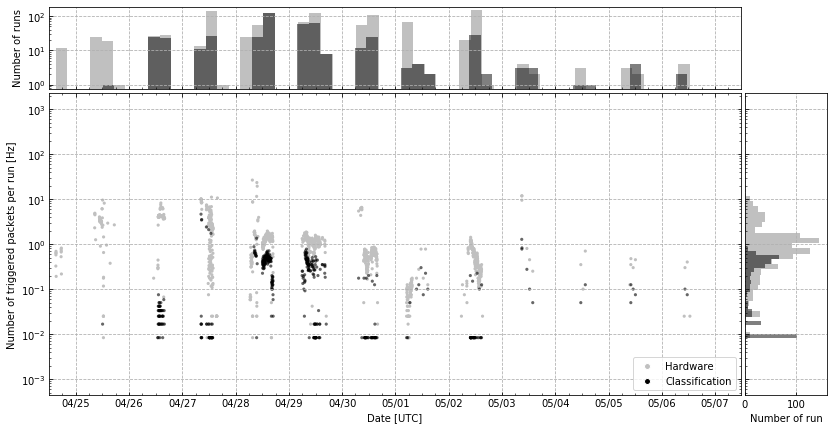

In [64]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Summary - mean trigger rate

In [65]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         1.1126859364435429
Mean trigger rate in classifer selected data: 0.2769770879526977


### Distribution of classified events

In [66]:
sns.set(style="whitegrid")

In [67]:
flight_df_nonan[manual_classification_class_name_column].value_counts()

unclassified              143713
dot                          454
top_left_ec                  353
blob                         300
noise                        255
bg_increased_suddenly        196
few_dots                     153
large_blob                   141
dot_w_blob_behind            133
bright_blob                   80
noise_with_week_dot           62
short_single_gtu_track        54
single_gtu_track              51
noise_unspecified             30
persistent_dot                29
cartesian_line                27
unspecified                   26
2pix_line                     24
blob_and_dots                 18
sparse_blobs                  14
storng_light                   3
Name: manual_classification_class_name, dtype: int64

Withount unclassified
All flight data in the selection


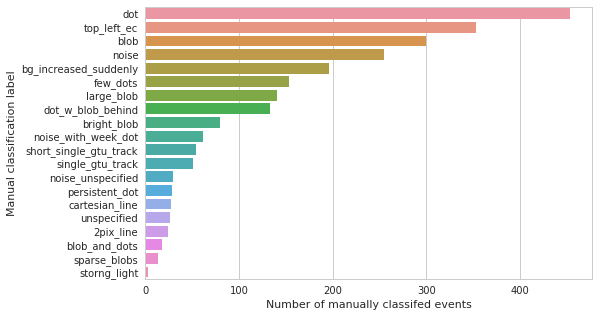

Events classified as positive


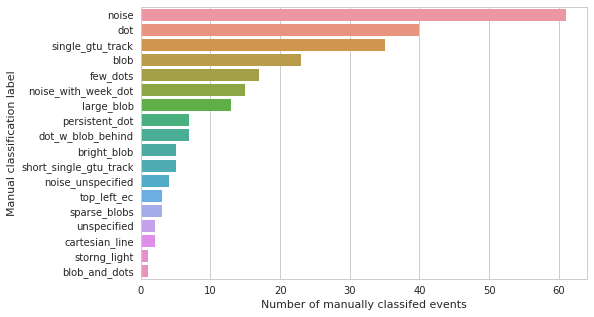

With unclassified
All flight data in the selection


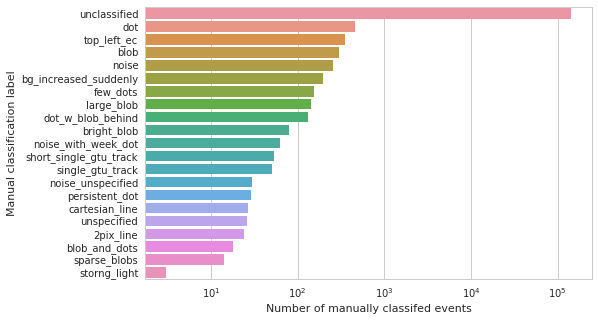

Events classified as positive


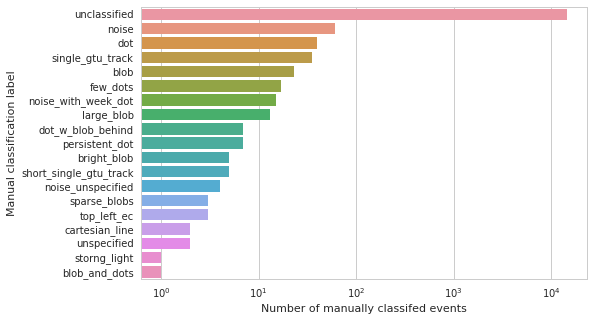

In [68]:
# requires manual_classification_class_name_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_nonan[flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_name_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_name_column].value_counts().index
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_data_manual_classification_class_name_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

In [69]:
w_unclassified = False
apply_air_shower_filter = True

subset_df = \
    flight_df_nonan[
        flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
    ] if not w_unclassified else flight_df_nonan

print('All flight data in the selection')
print(subset_df.groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Events classified as positive')
print(subset_df[subset_df[cls_column] == 1].groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Ratios')

flight_data_nonan_class_ratios_df = \
    subset_df.groupby([manual_classification_class_name_column])[cls_column] \
        .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

flight_data_nonan_class_ratios_df #[flight_data_nonan_class_ratios_df[cls_column] == 1]

All flight data in the selection
manual_classification_class_name
2pix_line                  24
bg_increased_suddenly     196
blob                      300
blob_and_dots              18
bright_blob                80
cartesian_line             27
dot                       454
dot_w_blob_behind         133
few_dots                  153
large_blob                141
noise                     255
noise_unspecified          30
noise_with_week_dot        62
persistent_dot             29
short_single_gtu_track     54
single_gtu_track           51
sparse_blobs               14
storng_light                3
top_left_ec               353
unspecified                26
Name: event_id, dtype: int64
--------------------------------------------------
Events classified as positive
manual_classification_class_name
blob                      23
blob_and_dots              1
bright_blob                5
cartesian_line             2
dot                       40
dot_w_blob_behind          7
few_dots         

,manual_classification_class_name,extra_trees_cls_on_train_rfecv_est_dropna,percentage
0,2pix_line,0,100.000000
34,top_left_ec,0,99.150142
32,storng_light,0,66.666667
30,sparse_blobs,0,78.571429
29,single_gtu_track,0,31.372549
26,short_single_gtu_track,0,90.740741
24,persistent_dot,0,75.862069
22,noise_with_week_dot,0,75.806452
20,noise_unspecified,0,86.666667
36,unspecified,0,92.307692


Withount unclassified


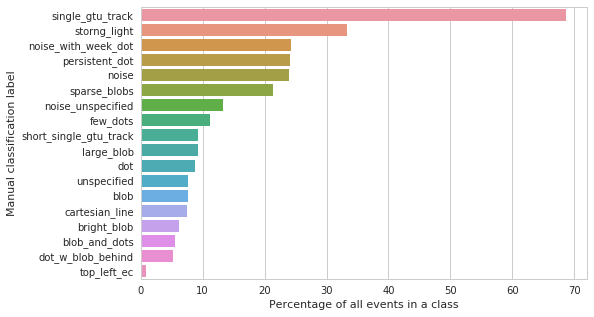

With unclassified


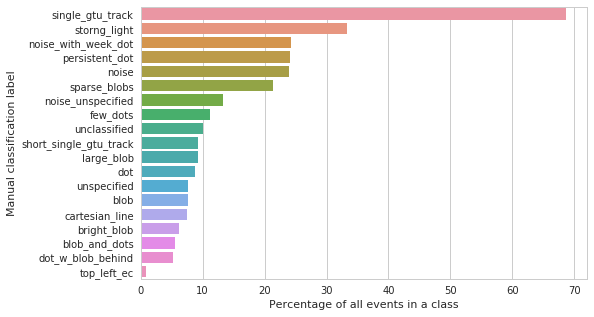

In [70]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_nonan[
            flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_name_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_name_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_name_column].iloc[
                        np.argsort(-subset_df["percentage"])]
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_data_manual_classification_class_name_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

In [71]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [72]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [73]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Already exists ver4_machine_learning_flight_classification_tsne_cfg3_20190409_2/flight_data.tsv.gz


# Visualization of the events

## Visualizing the features

In [74]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_count,trg_x_y_clusters_sizes_min,...,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number
0,11,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,2,1,...,74,4.60184,5.41446,5.14926,27,15,27,27,27,-1.0
1,11,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,1,7,...,38,1.70155,2.29509,3.20554,35,19,35,35,35,-1.0
2,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,74,3.15889,1.96062,3.85617,84,25,84,84,84,-1.0
3,9,1.0,1.0,0.111111,1.0,0.111111,1.0,0.111111,1,1,...,52,2.76942,3.05407,2.90978,57,22,57,57,57,-1.0
4,22,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,1,16,...,26,5.69936,5.69849,1.11428,46,45,46,46,46,-1.0


### Features used by the model

In [75]:
len(rfecv_selector_on_extra_trees__column_names)

171

In [76]:
importances = extra_trees_cls_on_train_rfecv_est.feature_importances_
indices = np.argsort(importances)[::-1]


rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(len(rfecv_selector_on_extra_trees__column_names)) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for column_name, column_indice, column_importance in \
        rfecv_selector_on_extra_trees__column_names_indices_importances__sorted:
    print('{:<70}{:.4f}'.format(column_name,column_importance))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0329
proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0245
proc3_x_y_hough_peak_thr1_line_clusters_count                         0.0237
alt1_x_y_hough_peak_thr1_line_clusters_count                          0.0226
alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width              0.0222
proc3_x_y_hough_peak_thr2_line_clusters_count                         0.0212
proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0195
proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width            0.0178
proc2_x_y_hough_peak_thr2_line_clusters_count                         0.0171
alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width             0.0169
proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0163
proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0156
proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0154

In [77]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [78]:
#event_v3_storage_provider_flight.connection.reset()

In [79]:
# flight_nonan_classified_shower_pathname = os.path.join(data_snippets_dir, 'flight_nonan_classified shower.tsv')

In [80]:
# flight_df_nonan[flight_df_nonan['extra_trees_cls_on_train_kbest400_128_est_dropna']==1].to_csv(flight_nonan_classified_shower_pathname, sep='\t')

In [81]:
# TODO select clusters with positive classification (sort by the number of classifications) show distribution of event types

In [82]:

# flight_df_nonan_subset[['dbscan_tsne_y','manual_classification_class_number'].hist('dbscan_tsne_y', figsize=(24,4), bins=2*len(dbscan_on_tsne_classes)+1)

# plt.show()

In [83]:
# THIS IS NOT WHAT IS DESIRED - values should be split into features ?
# flight_nonan__cls_tsneclu_corr_df = \
#     flight_df_nonan[['dbscan_tsne_y', 'manual_classification_class_number']].corr()
# f, ax = plt.subplots(figsize=(28,22))
# plt.close('all')
# sns.heatmap(flight_nonan__cls_tsneclu_corr_df, cmap='inferno', annot=True)
# plt.show()

In [84]:
#     f, ax = plt.subplots()
#     f.set_size_inches(8,4)
#     flight_df_nonan_subset[['dbscan_tsne_y', 'manual_classification_class_number']].plot.bar(by='dbscan_tsne_y', ax=ax)
    

In [85]:
# flight_nonan__tsne__gmm_y_pred = gmm.predict(flight_df_nonan[['tsne_X_0','tsne_X_1']].values)

In [86]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# extra_trees_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# extra_trees_classifier_on_train_kbest50__y_flight_pred = \
#     extra_trees_classifier_on_train_kbest50.predict(extra_trees_classifier_on_train_kbest50__X_flight)